In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load and Preprocess

In [7]:
# Set style
plt.style.use('ggplot')

# Use the full path you provided
file_path = r"C:\Users\PC\OneDrive\Desktop\avacado-sales\data\avocado.csv"
# Load the data
print("[1/5] Loading and Preprocessing Data...")
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

[1/5] Loading and Preprocessing Data...


In [6]:
# Filter for TotalUS and Conventional
mask = (df['region'] == 'TotalUS') & (df['type'] == 'conventional')
df_filtered = df[mask].sort_values('Date')
ts = df_filtered.set_index('Date')['AveragePrice'].resample('W-MON').mean().interpolate(method='linear')

print(f"Data Loaded: {len(ts)} weeks of data.")

Data Loaded: 169 weeks of data.


# 2. Load and Preprocess

[2/5] Generating EDA...


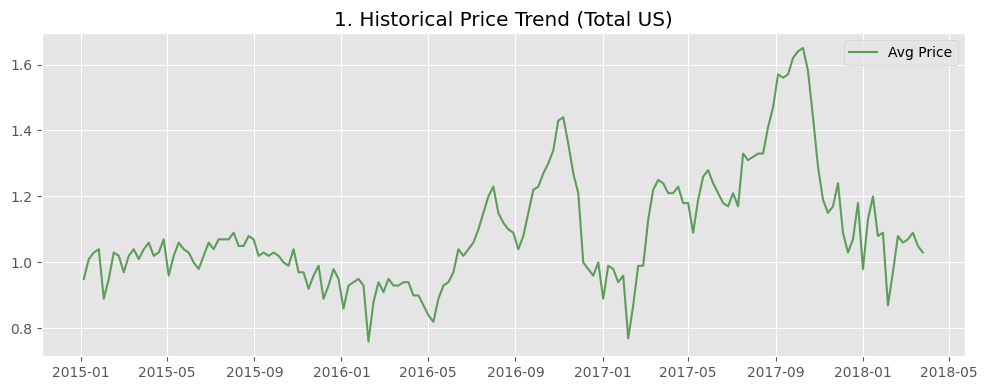

In [13]:
print("[2/5] Generating EDA...")

# Trend
plt.figure(figsize=(10, 4))
plt.plot(ts, color='#5D9C59', label='Avg Price')
plt.title('1. Historical Price Trend (Total US)')
plt.legend()
plt.tight_layout()
plt.savefig('1_trend.png')
plt.show()

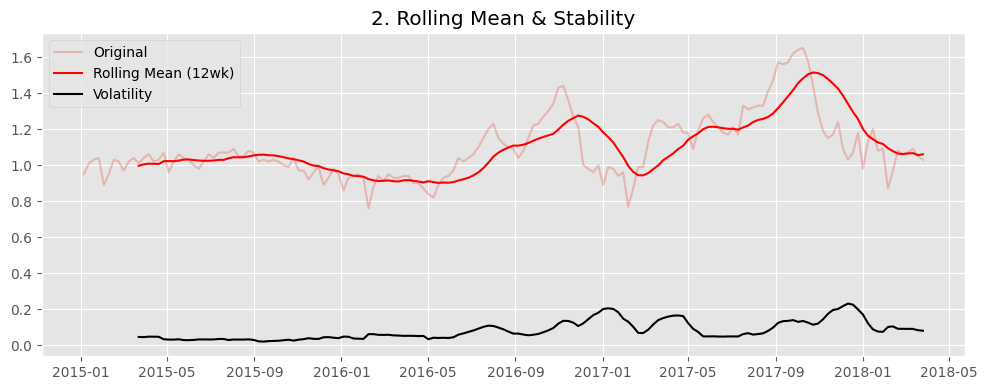

In [14]:
# Rolling
rolling_mean = ts.rolling(window=12).mean()
rolling_std = ts.rolling(window=12).std()
plt.figure(figsize=(10, 4))
plt.plot(ts, alpha=0.3, label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (12wk)')
plt.plot(rolling_std, color='black', label='Volatility')
plt.title('2. Rolling Mean & Stability')
plt.legend()
plt.tight_layout()
plt.savefig('2_rolling.png')
plt.show()

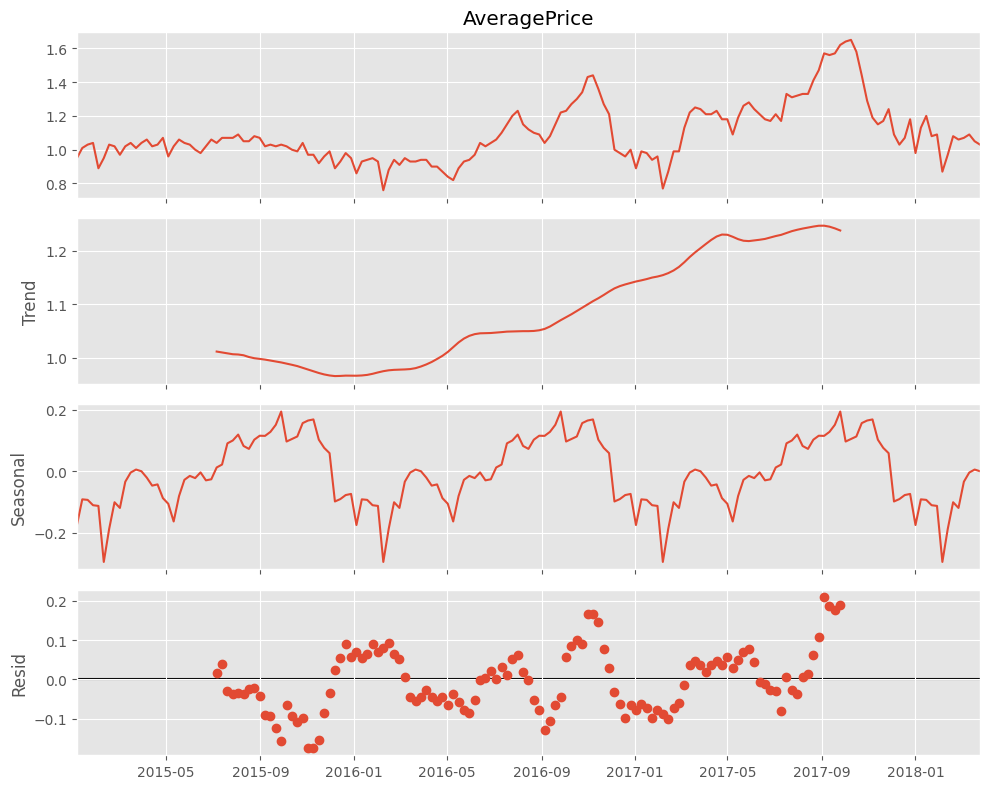

In [15]:
# Decomposition
decomp = seasonal_decompose(ts, model='additive', period=52)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.savefig('3_decomposition.png')
plt.show()

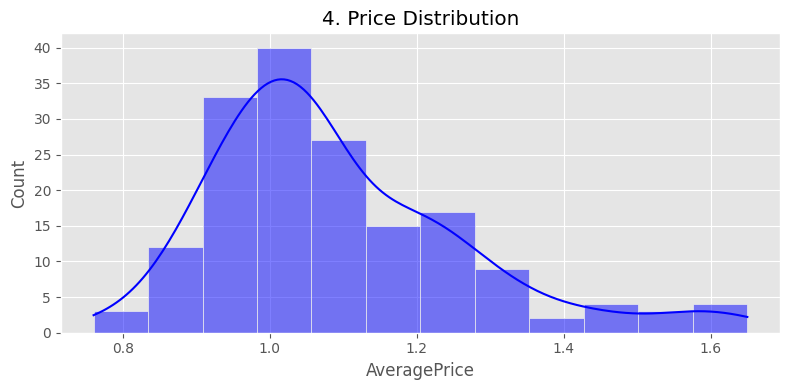

In [16]:
# Distribution
plt.figure(figsize=(8, 4))
sns.histplot(ts, kde=True, color='blue')
plt.title('4. Price Distribution')
plt.tight_layout()
plt.savefig('4_distribution.png')
plt.show()

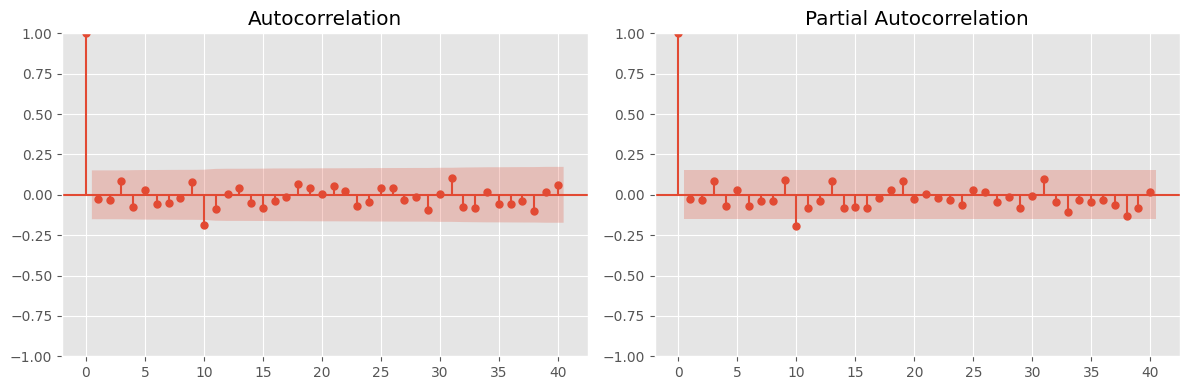

In [17]:
# ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts.diff().dropna(), ax=ax1, lags=40)
plot_pacf(ts.diff().dropna(), ax=ax2, lags=40)
plt.tight_layout()
plt.savefig('5_acf_pacf.png')
plt.show()

# 3. Stationarity


In [18]:

print("[3/5] Checking Stationarity...")
result = adfuller(ts)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

[3/5] Checking Stationarity...
ADF Statistic: -2.5733
p-value: 0.0986


# 4. Modelling

In [19]:
print("[4/5] Training SARIMA Model...")
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

forecast_res = results.get_forecast(steps=len(test))
pred_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Metrics
rmse = np.sqrt(mean_squared_error(test, pred_mean))
mae = mean_absolute_error(test, pred_mean)
mape = np.mean(np.abs((test - pred_mean) / test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

[4/5] Training SARIMA Model...


c:\Users\PC\OneDrive\Desktop\avacado-sales\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE: 0.2226
MAE: 0.1786
MAPE: 13.66%


# 5. Modelling

[5/5] plotting Final Forecast...


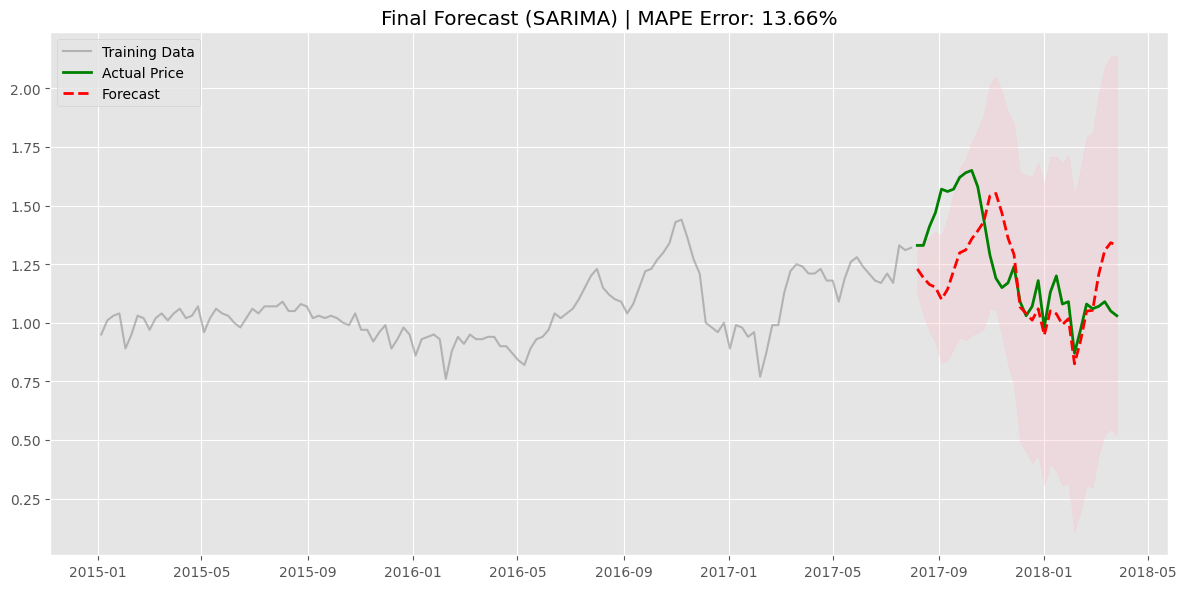

Done.


In [21]:
# --- 5. Final Plot ---
print("[5/5] plotting Final Forecast...")
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='gray', alpha=0.5)
plt.plot(test.index, test, label='Actual Price', color='green', linewidth=2)
plt.plot(test.index, pred_mean, label='Forecast', color='red', linestyle='--', linewidth=2)
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'Final Forecast (SARIMA) | MAPE Error: {mape:.2f}%')
plt.legend()
plt.tight_layout()
plt.savefig('6_final_forecast.png')
plt.show()

print("Done.")